## one method one figure

In [1]:
import numpy as np
from stdb import load_db 
import pygmt
import pandas as pd
import pickle
import glob, os
import warnings  
from obspy.core.event.catalog import read_events
warnings.filterwarnings("ignore")  

In [2]:
pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
            FONT_LABEL = '8',
            MAP_LABEL_OFFSET = '4p',
            MAP_TICK_LENGTH_PRIMARY = '5p',
#             PS_MEDIA ='A4',
            PROJ_LENGTH_UNIT = 'c',
            MAP_ANNOT_OFFSET_PRIMARY = '5p',
            MAP_ANNOT_OFFSET_SECONDARY = '5p',
            MAP_FRAME_TYPE = 'fancy',
            MAP_FRAME_WIDTH = 'auto',
            FORMAT_GEO_MAP = 'D',
            PS_CHAR_ENCODING = 'Standard+',
            MAP_FRAME_PEN = '2p,black')


def PygmtBegin(figmap, region):
#     grid = pygmt.datasets.load_earth_relief(resolution="30s", region=region)
    pygmt.makecpt(cmap="elevation", series=[0, 4000, 500],output = 'eleva.cpt', continuous=True)
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', 'nSeW'])
    figmap.grdimage('@earth_relief_30s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.25p')
##==========legned setting 
    figmap.plot(x=40.5,y=39.1,style="c0.5c", pen="black", no_clip=True)
    figmap.text(x=40.5,y=38.9,text='Null', font="12p,Times-Bold,black", no_clip=True)
    RCdata = [[41.5, 39.1, 0, 5, 1*40]]
    SCdata = [[41.5, 38.9, 0, 5, 1*40]]
    figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.01p,black", no_clip=True)
    figmap.text(x=42,y=39.1,text='RC', font="12p,Times-Bold,black", no_clip=True)
    figmap.plot(data=SCdata, style="J", color="red3", pen="0.01p,black", no_clip=True)
    figmap.text(x=42,y=38.9,text='SC', font="12p,Times-Bold,black", no_clip=True)
    legenddata=[[43, 39.1, 0, 5, 0.5*40],[43.8, 39.1, 0, 5, 1*40],[44.8, 39.1, 0, 5, 1.5*40]]
    figmap.plot(data=legenddata, style="J", color="black", pen="0.01p,black", no_clip=True)
    figmap.text(x=43,y=38.9,text='0.5s', font="12p,Times-Bold,black", no_clip=True)
    figmap.text(x=43.8,y=38.9,text='1s', font="12p,Times-Bold,black", no_clip=True)
    figmap.text(x=44.8,y=38.9,text='1.5s', font="12p,Times-Bold,black", no_clip=True)
    
def Plot_event(figmap, Event):
    figmap.shift_origin(xshift = '10c', yshift = '9c')
    lat = 42; lon = 44
    colfill = '217.6/217.6/217.6'
    figmap.coast(region='g', 
              projection = f'E{lon}/{lat}/180/8c', 
              resolution = 'c', 
              land = colfill, 
              shorelines ='1/0.1p,' + colfill, 
              C = colfill, 
              frame = True)

    figmap.plot(x = lon, y = lat, style ='s0.6c', pen ='0.2', color = 'red')

    distlims = [60,90,120,150]
    for dists in distlims:
        figmap.plot(x = lon, y = lat, style ='E-' + str(2 * dists) + 'd', 
                 pen ='1p,black,3_1:0p',t = '60')

    figmap.text(x = 44, y = -20,  text = f'60@.', font='9p')
    figmap.text(x = 44, y = -48,  text = '90@.', font='9p')
    figmap.text(x = 44, y = -79,  text = '120@.', font='9p')
    figmap.text(x = -137, y = -71,   text = '150@.', font='9p')
    if len(Event)>0:
        figmap.plot(x=Event['Lon'],y=Event['Lat'],
                sizes = np.exp(Event['Mag']/100)*0.52,
                color=Event['Dep'],cmap = 'cmapEQs.cpt' , style="a",pen="1p,black",transparency=40)

    with pygmt.config(FONT_ANNOT_PRIMARY = '12p,Times-Roman', FONT_LABEL = '15p,Times-Roman',
                      MAP_ANNOT_OFFSET_PRIMARY = '0.3c',
                      MAP_LABEL_OFFSET = '0.8c', 
                      MAP_TICK_LENGTH_PRIMARY = '0.2c',
                      MAP_FRAME_PEN = '0.6p'):    
        figmap.colorbar(cmap = 'cmapEQs.cpt', position = 'x9.5/0.55+w7c/0.4c+ml', frame = ['a100f50','+L"Depth (km)"'])    

In [3]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
Path = '/Volumes/home/Research/STEP/02_Station_result_csv/2015-2020_Mw6+7_85-100degree'
phase = 'SKS'
MAG = 6
DATApath = f'/Volumes/home/Research/STEP/01_Split/DATA_{phase}_Mw67_85-100'
evt_cata = 'Event_catalog_2015-2020_mw6+7_85-100.xml'
CATA = read_events(f'{DATApath}/{evt_cata}')
notplotLIST = ['TRLG','BRNG','GUDG']

SAVEpath = '/Volumes/home/Research/STEP/04_Station_result_map/2015-2020_Mw6+7_85-100'
filemag = 'Mw67_85-100'

In [4]:
def Event_clean():
    Ori_Event = {'Time':[],
            'Lat':[],
            'Lon':[],
            'Mag':[],
            'Dep':[] }
    for evt in CATA:
        yyyy = str(evt.origins[0].time.year).zfill(4)
        mm   = str(evt.origins[0].time.month).zfill(2)
        dd   = str(evt.origins[0].time.day).zfill(2)
        hh   = str(evt.origins[0].time.hour ).zfill(2)
        mi   = str(evt.origins[0].time.minute).zfill(2)
        ss   = str(evt.origins[0].time.second).zfill(2)
        TIME = f'{yyyy}{mm}{dd}_{hh}{mi}{ss}'
        lat = evt.origins[0].latitude; lon = evt.origins[0].longitude
        mag = evt.magnitudes[0].mag
        dep = evt.origins[0].depth/1000
        Ori_Event['Time'].append(TIME)
        Ori_Event['Lat'].append(lat)
        Ori_Event['Lon'].append(lon)
        Ori_Event['Mag'].append(mag)
        Ori_Event['Dep'].append(dep)
    return Ori_Event

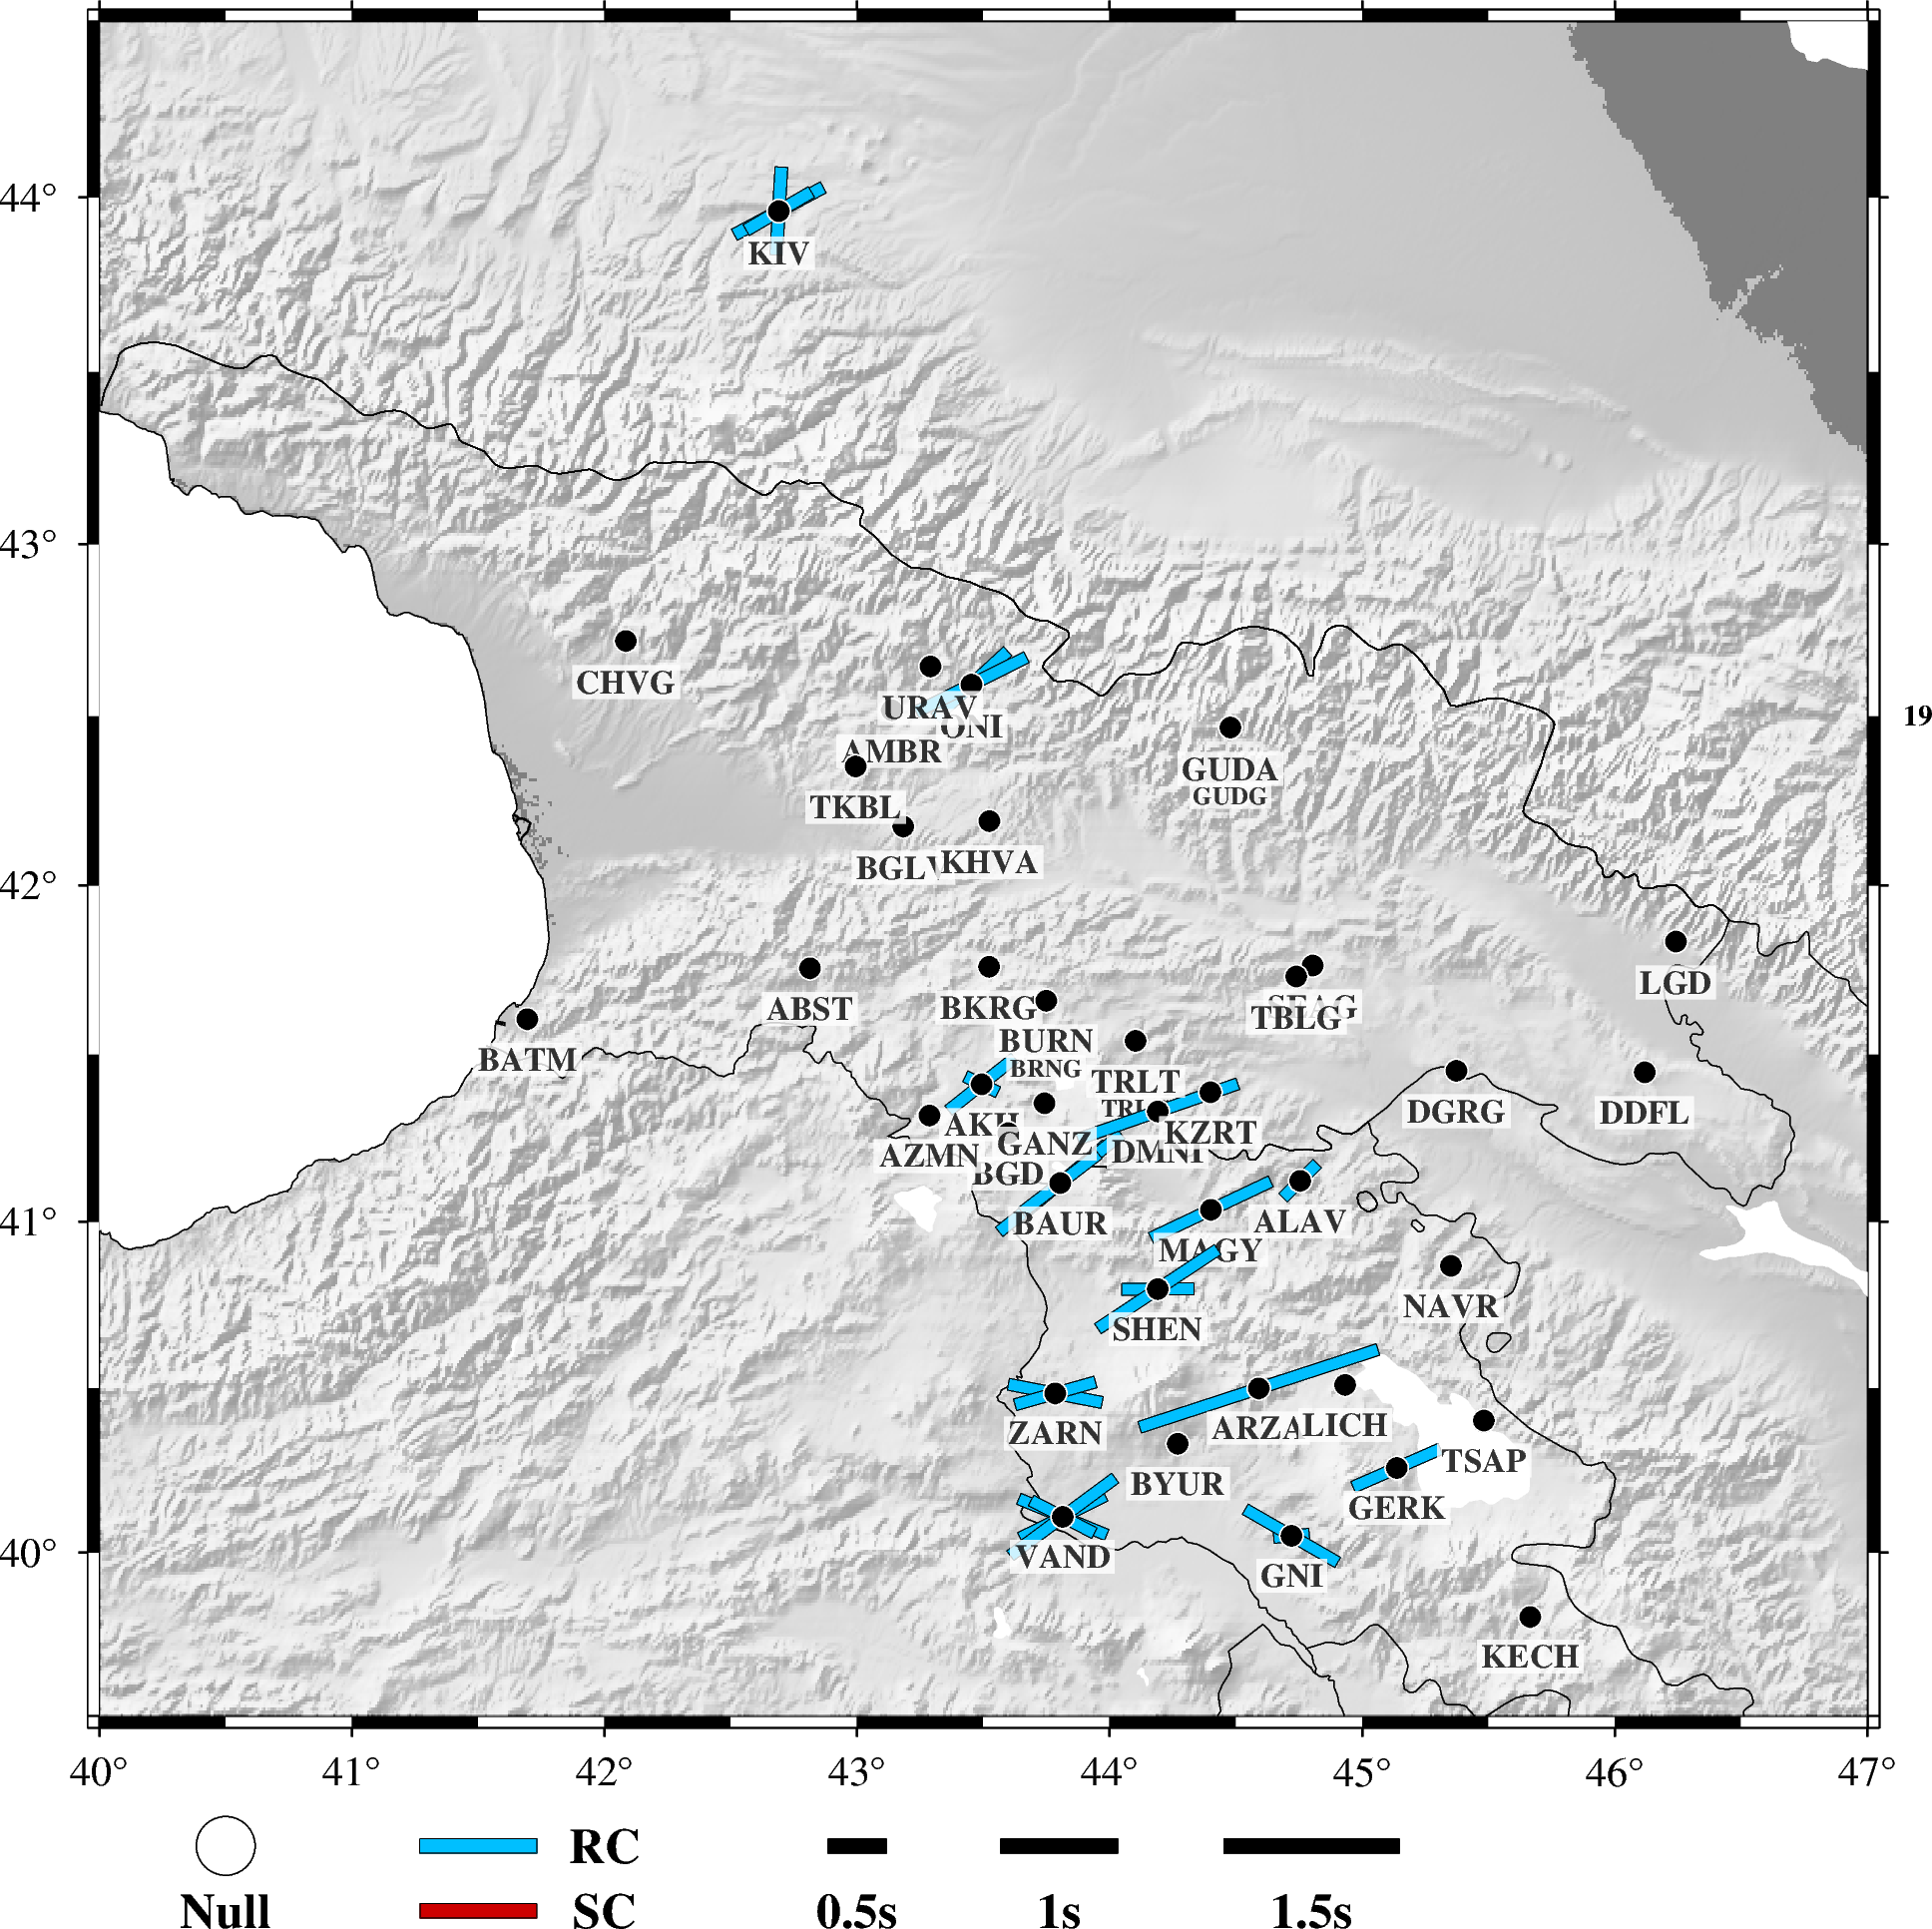

In [5]:
##==================for non-Null Good condition 
Ori_Event = Event_clean()
regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals)

USEevent=[]
for CSVpath in sorted(glob.glob(f'{Path}/*.csv')):
    filename = CSVpath.rsplit('/')[-1]
    netsta = filename.rsplit('_')[0]
    NET = netsta.rsplit('.')[0] ; STA = netsta.rsplit('.')[1]
    STApkl = pickle.load(open(f'{PKLpath}/{NET}_{STA}.pkl', "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    st_lat = values['latitude']; st_lon = values['longitude']
    df = pd.read_csv(CSVpath)
    
    df = df[df['Phase']==phase][df['SNRQ']>=5][df['Pick']==True]#[df['Mag']>=MAG]
    
    
    for i in range(len(df)):
        RCPhi = df['RCPhi'].values[i]
        RCdt  = df['RCdt'].values[i]
#         SCPhi = df['SCPhi'].values[i]
#         SCdt  = df['SCdt'].values[i]

        if df["CpH"].values[i] >= 0.77 : pass
        else: 
            RCdata = [[st_lon, st_lat, RCPhi-90, 4, RCdt*40]]
            figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.01p,black")    

            evtTime = df["Event"].values[i]
#             print(f'{STA} {evtTime}')
            if evtTime not in USEevent:   
                USEevent.append(evtTime)
                
        
    figmap.plot(x=st_lon, y=st_lat, style="c0.2c",color='black', pen="white")
    if STA not in notplotLIST :
        figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="8p,Times-Bold,black",fill='white',transparency=20)
    else : 
        figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="6p,Times-Bold,black",fill='white',transparency=20)



##============= clean up catalog I used 
Event = Ori_Event.copy()
removelist = [x for x in Event['Time'] if x not in USEevent]
for reevent in removelist:
    index = Event['Time'].index(reevent)
    for keys in Event:
        Event[keys].pop(index)
NEWEvent=pd.DataFrame(Event)    
num_evt = len(NEWEvent)
figmap.text(x=47.2,y=42.5,text=f'{num_evt}',font="7p,Times-Bold,black", no_clip=True)    
##============= plot earthquake distribution  
# Plot_event(figmap, NEWEvent)
figmap.savefig(f'{SAVEpath}/08_Plot_Station_PCA76_RC_{filemag}.pdf')
figmap.savefig(f'{SAVEpath}/08_Plot_Station_PCA76_RC_{filemag}.png')
figmap.show()

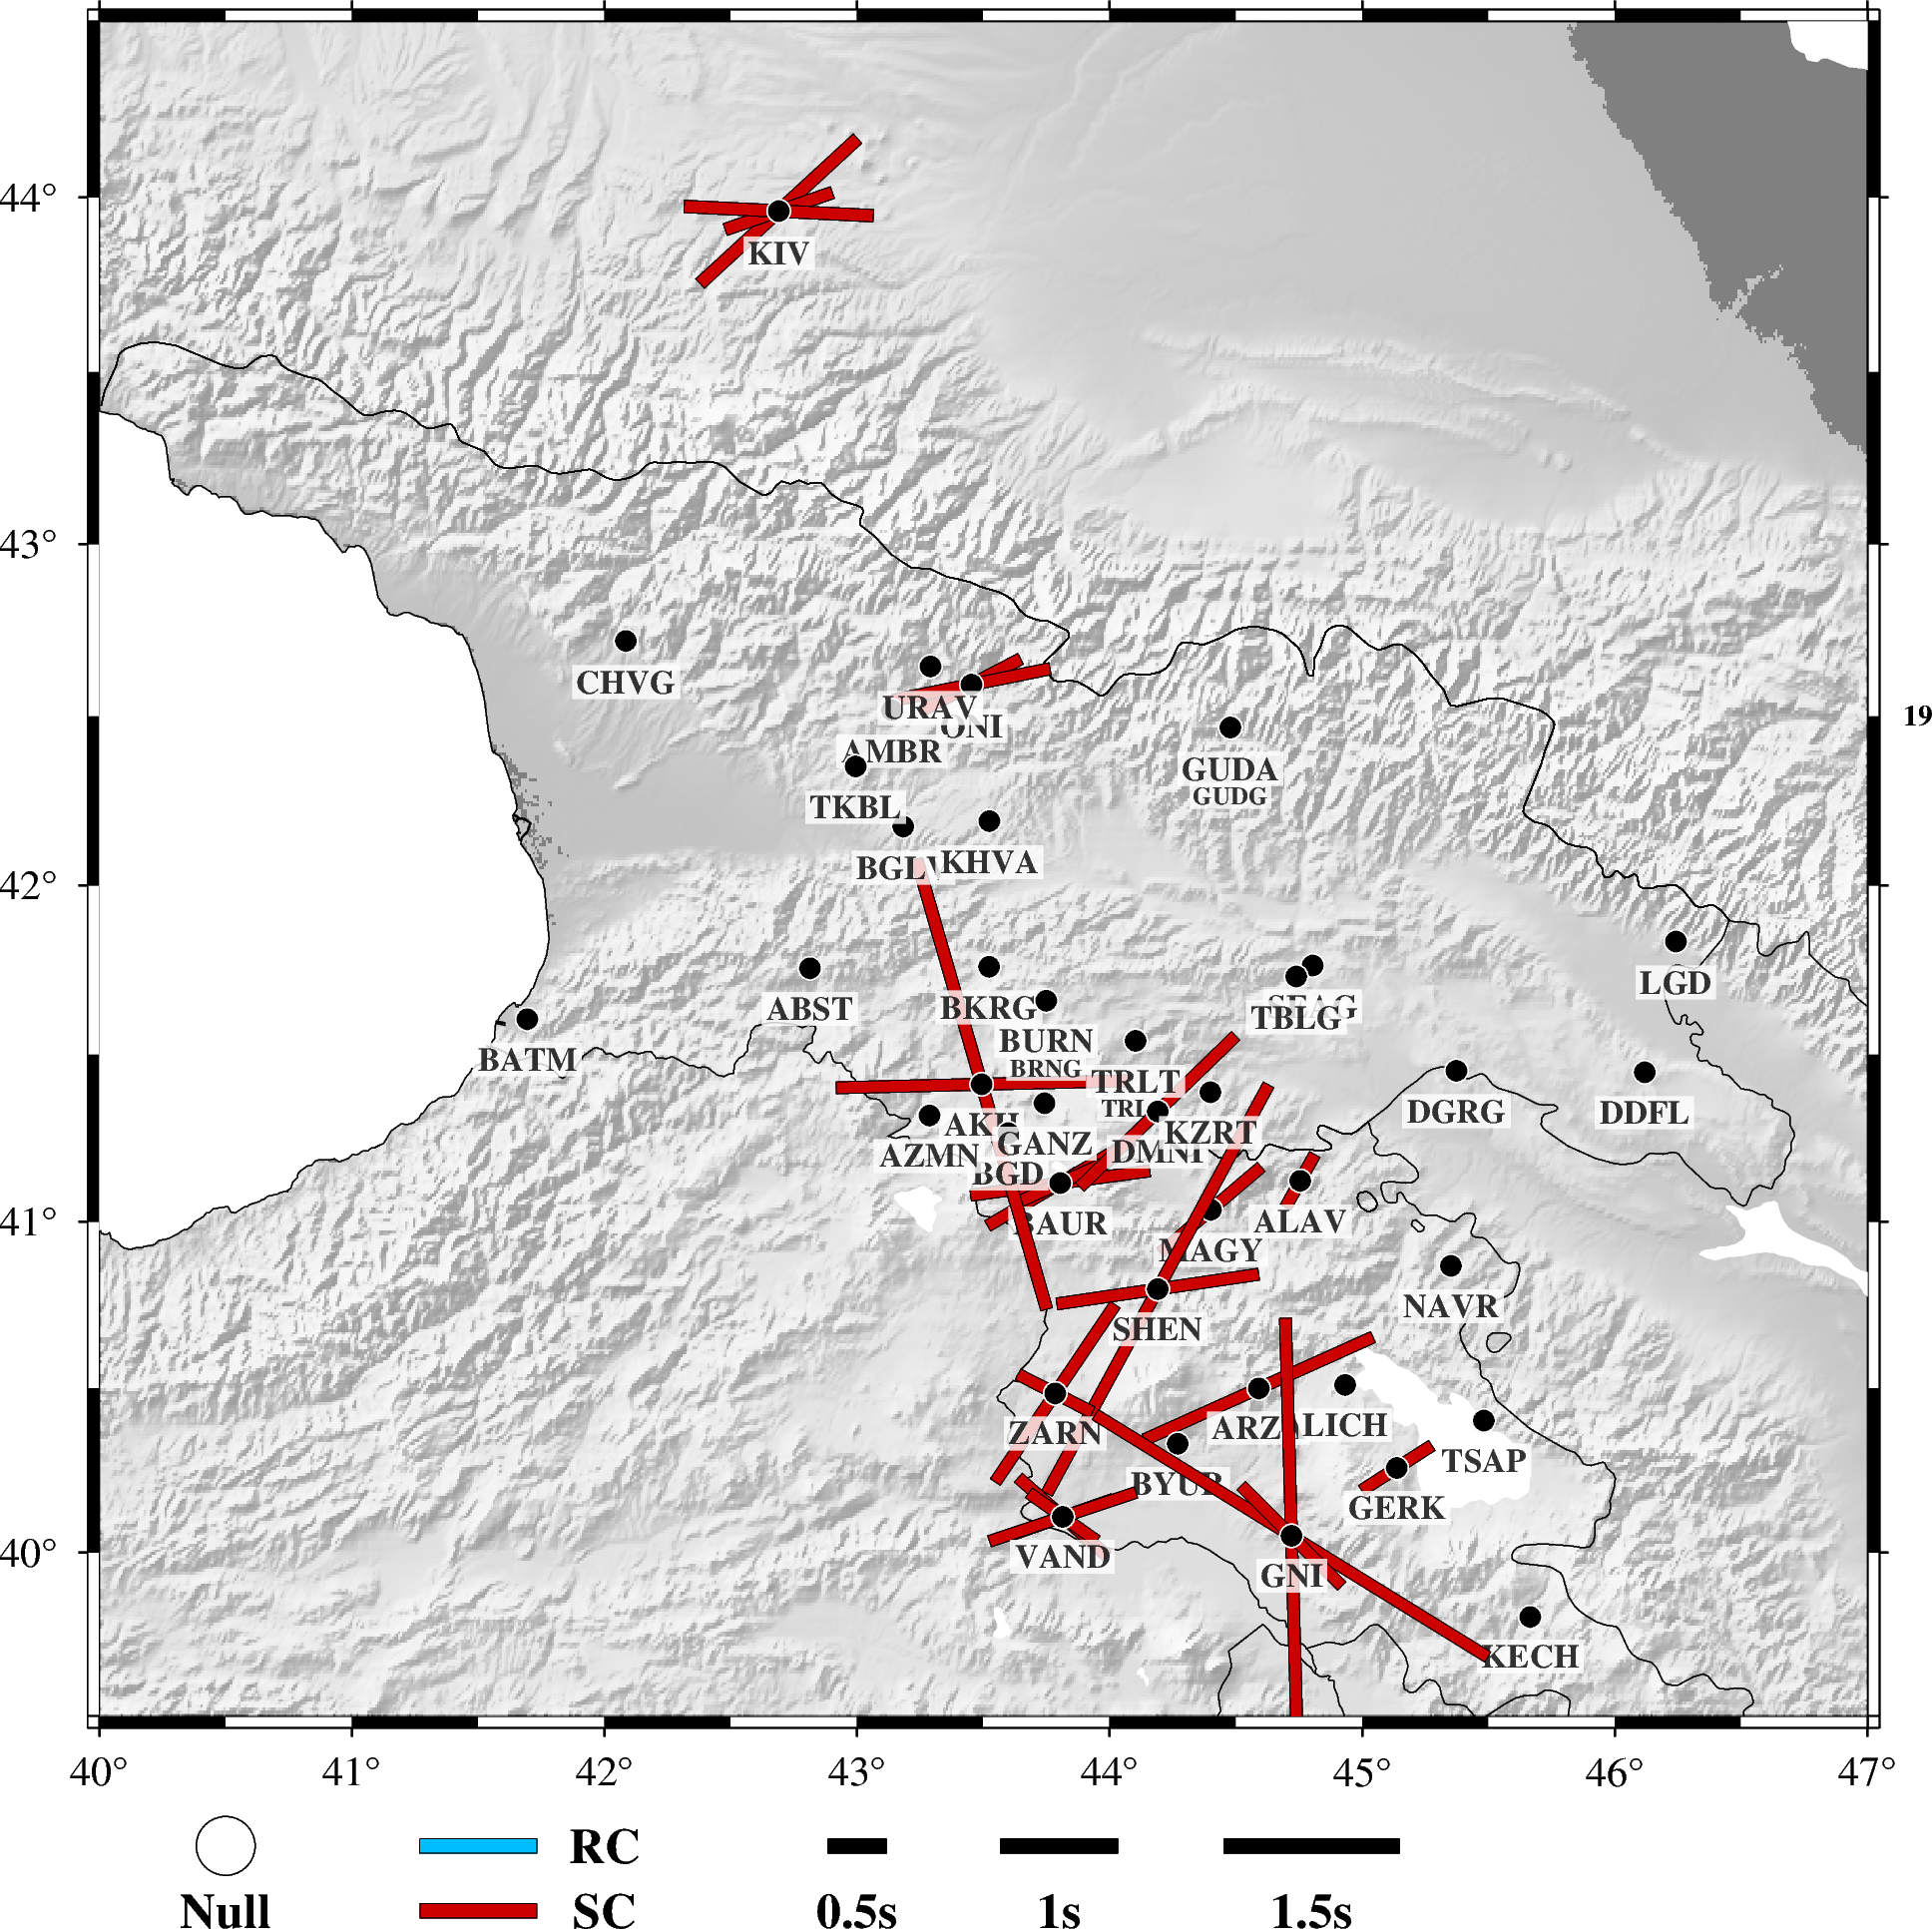

In [6]:
##==================for non-Null Good condition 
Ori_Event = Event_clean()
regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals)

USEevent=[]
for CSVpath in sorted(glob.glob(f'{Path}/*.csv')):
    filename = CSVpath.rsplit('/')[-1]
    netsta = filename.rsplit('_')[0]
    NET = netsta.rsplit('.')[0] ; STA = netsta.rsplit('.')[1]
    STApkl = pickle.load(open(f'{PKLpath}/{NET}_{STA}.pkl', "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    st_lat = values['latitude']; st_lon = values['longitude']
    df = pd.read_csv(CSVpath)
    
    df = df[df['Phase']==phase][df['SNRQ']>=5][df['Pick']==True]#[df['Mag']>=MAG]
    
    
    for i in range(len(df)):
        SCPhi = df['SCPhi'].values[i]
        SCdt  = df['SCdt'].values[i]

        if df["CpH"].values[i] >= 0.77 : pass
        else: 
            
            SCdata = [[st_lon, st_lat, SCPhi-90, 4, SCdt*40]]
            figmap.plot(data=SCdata, style="J", color="red3", pen="0.01p,black")    

            evtTime = df["Event"].values[i]
#             print(f'{STA} {evtTime}')
            if evtTime not in USEevent:   
                USEevent.append(evtTime)
                
        
    figmap.plot(x=st_lon, y=st_lat, style="c0.2c",color='black', pen="white")
    if STA not in notplotLIST :
        figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="8p,Times-Bold,black",fill='white',transparency=20)
    else : 
        figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="6p,Times-Bold,black",fill='white',transparency=20)



##============= clean up catalog I used 
Event = Ori_Event.copy()
removelist = [x for x in Event['Time'] if x not in USEevent]
for reevent in removelist:
    index = Event['Time'].index(reevent)
    for keys in Event:
        Event[keys].pop(index)
NEWEvent=pd.DataFrame(Event)    
num_evt = len(NEWEvent)
figmap.text(x=47.2,y=42.5,text=f'{num_evt}',font="7p,Times-Bold,black", no_clip=True)    
##============= plot earthquake distribution  
# Plot_event(figmap, NEWEvent)
figmap.savefig(f'{SAVEpath}/09_Plot_Station_PCA76_SC_{filemag}.pdf')
figmap.savefig(f'{SAVEpath}/09_Plot_Station_PCA76_SC_{filemag}.png')
figmap.show()